In [ ]:
#| default_exp netana_ex04

In [ ]:

#| hide
from nbdev.showdoc import *

In [ ]:
from graph_tool.all import *

# Assignment 4
## Exercise 1
(2 points)
* Execute the Kernighan-Lin partitioning variant as given in the lecture in
the following network, where the starting partitions are given by the colours.
* Try to find a starting partition that changes the outcome. Either provide it with the changed outcome or try to explain why it is not possible.


In [ ]:
%load_ext jupyter_tikz

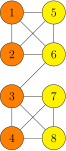

In [ ]:
%%tikz
\begin{tikzpicture}[scale=1.5, every node/.style={circle,draw,inner sep=5pt,font=\large}]
  % nodes
  \node (1) at (0,0) [fill=orange] {1};
  \node (2) at (0,-1) [fill=orange] {2};
  \node (3) at (0,-2) [fill=orange] {3};
  \node (4) at (0,-3) [fill=orange] {4};
  \node (5) at (1,0) [fill=yellow] {5};
  \node (6) at (1,-1) [fill=yellow] {6};
  \node (7) at (1,-2) [fill=yellow]{7};
  \node (8) at (1,-3) [fill=yellow] {8};

  % edges
  \draw (1) -- (2)
        (1) -- (5)
        (1) -- (6)
        (2) -- (5)
        (2) -- (6)
        (3) -- (4)
        (3) -- (6)
        (3) -- (7)
        (3) -- (8)
        (4) -- (7)
        (4) -- (8)
        (5) -- (6)
        (7) -- (8);
\end{tikzpicture}


**To provide a solution to the exercise:**
Provide the D values for each step and the maximum gain for the selection of the swap. Indicate the change of partitions from the swaps (preferred: visually), including the selected nodes, as well as the fixed nodes in each step. List the cut costs for each step and the selected prefix of swaps, too. Provide a starting partition or argument.

#### How is the Kernighan-Lin partitioning variant described in the lecture?
There is something about starting partitions given as colors. So probably we already have a preselection and we are now only optimizing this selection to get a better fit for the network.



Ok we are missing the network that we should execute the Kernighan-Lin partitioning on.


Finding a starting partition that changes the outcome, so select different colors that then result in a different partition just because of this starting set.

What do i actually need to do in practice? So how do i actually produce valid results? Sounds like a lot of text, some numbers and essentially following through a set of predefined steps and reporting these metrics and my reasoning at each step.



$D$ Values

There are multiple steps as it seems in Kernighan-Lin

Maximum Gain for the selection of the swap - whatever this means

Change of partitions from the swaps -> visually (so draw a picture)

selected nodes

fixed nodes in each step

List cut costs for each step

Selected prefix of swaps

Starting partition and argument


The argument is obviously that no matter which starting arrangement is chosen you will always arrive at the optimal solution since you try out every possibility. The only version i could think of is one that basically lures a first swap that makes the optimal set impossible in the beginning and since these nodes are already locked in the beginning the optimal solution of cut size 1 can never be reached. This could be a possibility that we can look into for finding. But nonetheless it is otherwise very unlikely with this algorithm.

The required solution is exactly what is demonstrated in this [Video](https://www.youtube.com/watch?v=GsMZYDBFJv4&t=1429s)

In [ ]:
g = Graph(directed=False)

In [ ]:
g.add_edge_list([(1, 2),(1,5), (1,6), (2,5), (2,6), (3,6), (3,7), (3,8), (3,4), (4,8), (4,7),  (5,6),(7,8)])

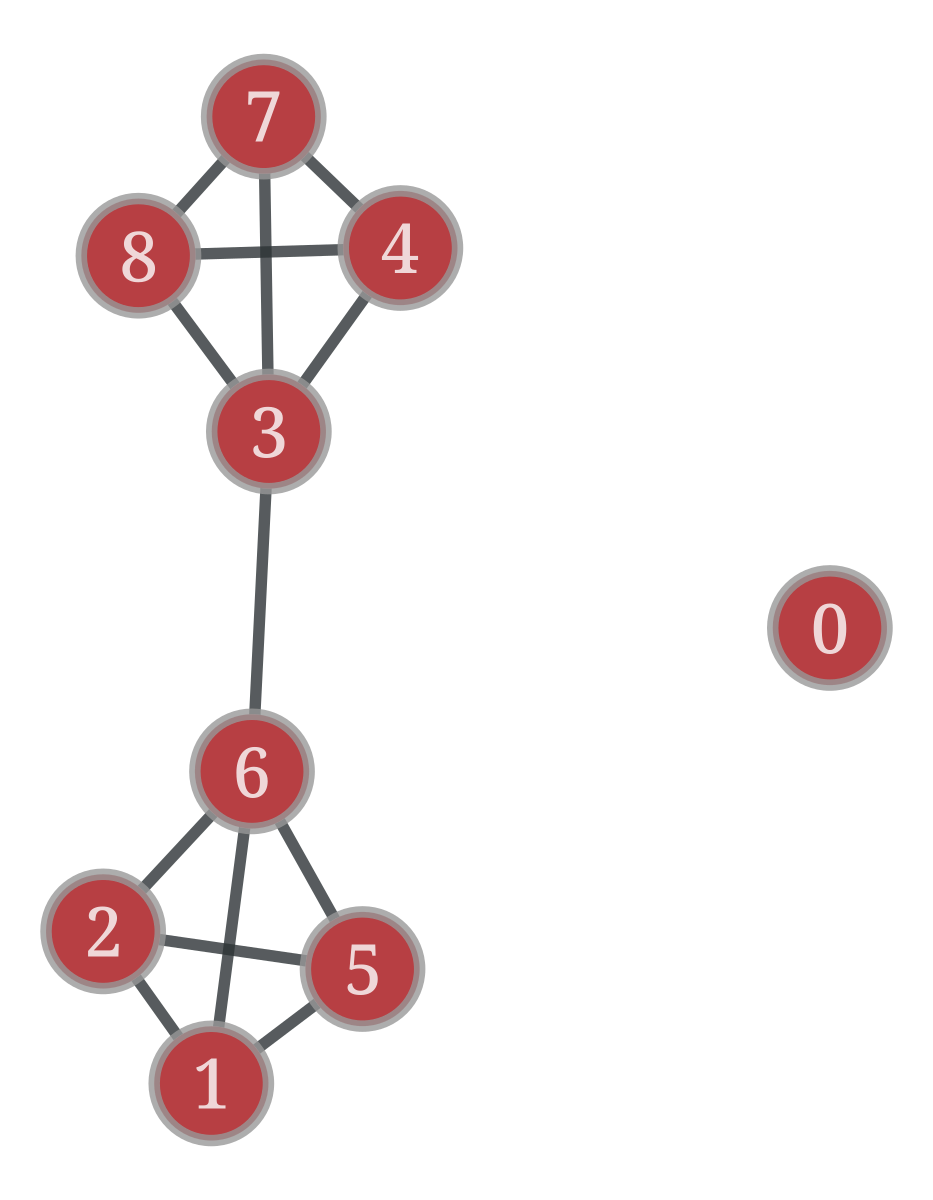

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f58d3e3c0e0,>

In [ ]:
graph_draw(g, vertex_text=g.vertex_index)

## Exercise 2 Modularity
(3 points)
* Experiment with modularity optimisation in your favorite software. Calculate
modularity values (e.g. in networkx) for the “non-intuitive” example networks given in the lecture.
*  Optimise modularity for the following graph consisting of a ring of same-size cliques and neighbouring cliques connected via a single link. Determine the modularity of a clustering in which each clique is its own cluster, and of the clustering where two neighbouring cliques are forming a cluster.
* Proof that a clustering with optimal modularity has no cluster with a single node of
degree 1.
*  Extra(not mandatory): Given a line graph, a path of N nodes. Show that if we divide the network into two parts by cutting a line, with r and N-r nodes each part, then the modularity is $$\frac{3 − 4𝑛 + 4𝑟𝑛 − 4𝑟^2}{2(𝑛 − 1)^2}$$
Hence show that if N is even, the optimal division for modularity is splitting the graph exactly in the middle.


**To provide a solution to the exercise:**
Provide the modularity values (a), the best modularity optimising community structure you can find (b) drawing, argument, and the proof(s).

This Exercise is already part of the community detection section. So Lecture 7 essentially. I first need to get that into my head before i can tackle that. '

## Exercise 3
(2 points)
* Consider the following small network
To provide a solution to the exercise:
Calculate for each of the 10 pairs of nodes the cosine similarity. Based on the values,
construct the dendrogram for the single-linkage hierarchical clustering of the network.

Ok the exercise is about hierarchical clustering

Clustering is also part of lecture 7 and comes after community detection. Clustering just has this special goal of having a similarity metric. So you are not just looking for communities based on minimizing the cut size between the communities and basically having this as your similarity metric. But you could have an arbitrary similarity metric that can also have to do with some of the additional data contained in the nodes. So this clustering is also something that is done in normal data analysis where you just have structured data. So graph clustering is like this but with the additional Network structure on top.


## Exercise 4
(3 points) Clustering

Execute partitioning/community detection/clustering on two networks of your chosing (but with more than 100 nodes).

See for example for networkx the documentation on communities to find supported methods, but feel free to use a different tool or framework (note that Leiden and Louvain are implemented).

a) Apply a partitioning / community detection method on your networks.

b) Apply a hierarchical clustering on your networks.

c) Draw the networks with the partitions / communities mapped to visual variables (e.g. color). Report the images and shortly discuss if you think the results can be improved.

d) Draw the dendrogram from the hierarchical clustering and report it.

e) Find a level in the dendrogram that you consider a good clustering. Report it and shortly explain why it is better than the others.

In [ ]:

#| hide
import nbdev;nbdev.nbdev_export()